# FDMS - TME 4

### Imports

In [179]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

In [190]:
features = ["f" + str(i) for i in range(5)]
choices  = ["c" + str(i) for i in range(10)]

In [22]:
data = pd.read_csv("CTR.txt", 
            delimiter=";", 
            names=["index"] + features + choices,
            index_col=0)

In [192]:
# Représentation des articles
description = data[features]
description.sample(3)

,f0,f1,f2,f3,f4
index,,,,,
3723,0.602076,0.977880,0.251563,0.653219,0.354012
2462,0.067320,0.884873,0.325171,0.836792,0.298278
3895,0.895563,0.030296,0.211242,0.997241,0.227947


In [28]:
# Nombre de clics selon le choix de l'annonceur (récompenses)
clics_rates = data[choices]
clics_rates.sample(3)

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
index,,,,,,,,,,
4288,0.000000,0.014984,0.0,0.309633,0.0,0.0,0.000000,0.118136,0.0,0.206772
3454,0.032343,0.063892,0.0,0.299404,0.0,0.0,0.022247,0.130235,0.0,0.261285
671,0.000000,0.027467,0.0,0.235185,0.0,0.0,0.030481,0.000000,0.0,0.286142


### Baselines

On définit une classe abstraite Bandit qui encapsulera les différents algorithmes que nous expérimenterons.

In [578]:
class Bandit(object):
    
    def __init__(self, choices):
        '''
            Initializes a simple bandit object.
            
            :param choices: A list of avaiable choices for the bandit
        '''
        
        self.choix = choices               # Label of choices
        self.state = [0 for c in choices]  # Number of occurences each choices has ben chosen
        self.score = [0 for c in choices]  # Reward gained by each choice
        self.lastp = None                  # Last prediction made by the bandit
        self.trace = []                    # History of choices (per iteration)
        self.t     = 0                     # Current iteration

        
    def compute(self):
        '''
            Compute a prediction of the bandit, based on the internally stored state.
            
            Contains the main logic of the Bandit algorith.
            
            :return: The selected choice
        '''
        raise NotImplementedError
        
        
    def predict(self, context=None):
        '''
            Apply the next prediction of the bandit
            
            :param row: Used of cheating bandits only
            :return: The selected choice
        '''
        
        if context is not None:
            self.context = context
        self.lastp = self.compute()
        self.state[self.lastp] += 1
        self.t += 1
        return self.choix[self.lastp]
    
    
    def reward(self, value):
        '''
            :param value: the reward value
            :type value: float
        '''
        if self.lastp is not None:
            self.score[self.lastp] += value
            self.trace.append([self.choix[self.lastp], value])
            self.lastp = None
    
    
class Rewarder(object):
    
    def __init__(self, context, rewards, bandits):
        self.context = context
        self.rewards = rewards
        self.bandits = bandits
        
    def run(self):
        for i in range(len(self.context.index)):
            for bandit in self.bandits:
                prediction = bandit.predict(self.context[i:i+1])
                bandit.reward(self.rewards.iloc[i].loc[prediction])
                
    def get(self):
        g = []
        for b in self.bandits:
            l = []
            n = 0
            c = 0
            for i in b.trace:
                n+=1
                c+=i[1]
                l.append(c/n)
            g.append(l)
        return np.array(g)

On implémente trois algorithmes de base qui serviront de témoins : un bandit aléatoire, un bandit tricheur qui choisit toujours le choix ayant le meilleur rendement moyen, et un bandit omniscient qui choisit le meilleur choix à chaque fois.
Les algorithmes expérimentés par la suite devraient pouvoir tendre vers les résultats du bandit tricheur.

In [255]:
def random(ind = 'c'):
    pubs = [i for i in list(data) if i[0] == ind]
    return np.random.choice(pubs)

class RandomBandit(Bandit):
    def compute(self):
        return np.random.choice(range(len(self.choix)))

In [245]:
def staticBest(data, ind = 'c'):
    pubs = [i for i in list(data) if i[0] == ind]
    return data[pubs].sum(axis=0).idxmax()

class StaticBestBandit(Bandit):
    def __init__(self, choices, rates):
        super().__init__(choices)
        self.best = self.choix.index(rates.sum(axis=0).idxmax())
        
    def compute(self):
        return self.best

In [274]:
def staticOptimal(data, row, ind = 'c'):
    pubs = [i for i in list(data) if i[0] == ind]
    return data[pubs].loc[row].idxmax()

class StaticOptimalBandit(Bandit):
    def __init__(self, choices, rates):
        super().__init__(choices)
        self.data = rates
        
    def compute(self):
        return self.choix.index(self.data.loc[self.context.index[0]].idxmax())

In [464]:
randomB  = RandomBandit(choices)
staticBB = StaticBestBandit(choices, clics_rates)
staticOB = StaticOptimalBandit(choices, clics_rates)
witnesses = [randomB, staticBB, staticOB]

### UCB

In [248]:
#TODO DELETE

class UCB(QLearn):
    def __init__(self):
        '''self.p : {poss : {v: <float>, s:<int>}}'''
        self.p = dict()
        self.t = 0

    def predict(self, state, poss):
        bmax = -float("inf")
        for c in poss:
            d = self.p.get(c, {'v':0.,'s':0})
            b = d['v']/d['s'] + np.sqrt(2*np.log(self.t)/d['s'])
            if b > bmax : 
                bmax = b
                self.actual = c
        self.p[self.actual] = self.p.get(self.actual, {'v':0.,'s':0})
        self.p[self.actual]['s'] += 1
        return self.actual

    def reward(self, value):
        self.p[self.actual]['v'] += value
        


NameError: name 'QLearn' is not defined

In [249]:
class UCBBandit(Bandit):
    def compute(self):
        b = -float("inf")
        for c in range(len(self.choix)):
            if self.state[c] == 0:  # Initialisation
                return c
            
            nb = self.score[c]/self.state[c] + np.sqrt(2*np.log(self.t)/self.state[c])
            if nb > b:
                b = nb
                r = c
        return r

In [543]:
class LinUCBBandit(Bandit):
    def __init__(self, choices, alpha=0.5):
        super().__init__(choices)
        self.A = None
        self.B = None
        self.alpha = alpha
        
    def compute(self):
        ct = np.array(self.context)[0]
        
        lc = len(self.choix)        # Nombre de choix
        ld = ct.shape[0]            # Dimension du contexte
        
        if self.A is None:          # Initialisation
            self.A = np.array([np.identity(ld) for i in range(lc)])
            self.B = np.zeros((lc, ld))
            
        t = np.zeros((lc, ld, 1))
        p = -float("inf")
        r = None
        
        for c in range(lc):
            t[c] = np.linalg.inv(self.A[c]).dot(self.B[c].reshape((-1, 1)))
            mp = ct.dot(t[c]) + self.alpha * \
                 np.sqrt(ct.dot(np.linalg.inv(self.A[c])).dot(ct.reshape((-1, 1))))
                 
            if mp > p:
                p = mp
                r = c
            
        return r
        
        
    def reward(self, value):
        '''
            :param value: the reward value
            :type value: float
        '''
        if self.lastp is not None:
            ct = np.array(self.context)
            self.A[self.lastp] += ct * ct.T
            self.B[self.lastp] += value * ct.reshape((5,))
            
            self.score[self.lastp] += value
            self.trace.append([self.choix[self.lastp], value])
            self.lastp = None

Nous expérimentons les deux algorithmes sur une série de 5000 étapes générées artificiellement.
On instancie un exemplaire de chaque bandit témoin, ainsi qu'un UCB et plusieurs instances du LinearUCB en faisant vaier à chaque fois la valeur _alpha_ pondérant la part du contexte dans la prédiction

In [579]:
witness = [RandomBandit(choices), 
           StaticBestBandit(choices, clics_rates),
           StaticOptimalBandit(choices, clics_rates)]

ucb     = [UCBBandit(choices)]

linucb  = [LinUCBBandit(choices, 10),
           LinUCBBandit(choices, 2),
           LinUCBBandit(choices, 0.5),
           LinUCBBandit(choices, 0.05)]

bandits = witness + ucb + linucb

trainer = Rewarder(description, clics_rates, bandits)

In [580]:
trainer.run()

In [599]:
k = trainer.get().T

Comparaison entre :
* Témoin Random (en bleu)
* Témoin Tricheur Moyen (en orange)
* Témoin Tricheur Omniscient (en vert)
* Algorithme UCB (en rouge)

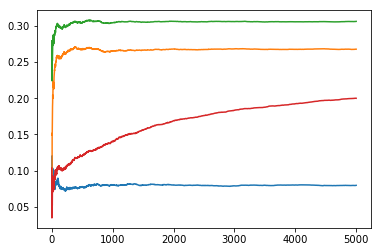

In [600]:
plt.plot(k[:,:4])
plt.show()

Comparaison entre les différents LinUCB avec :
* alpha = 10 (en bleu)
* alpha = 2 (en orange)
* alpha = .5 (en vert)
* alpha = .05 (en rouge)

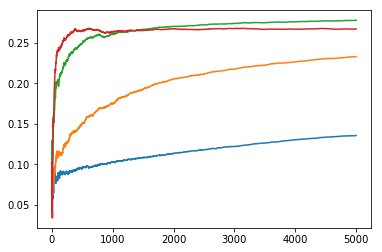

In [602]:
plt.plot(k[:,4:])
plt.show()

Comparaison entre : 
* Témoin Random (en bleu)
* Témoin Tricheur Moyen (en orange)
* Témoin Tricheur Omniscient (en vert)
* Meilleur algorithme LinUCB (0.5) (en rouge)

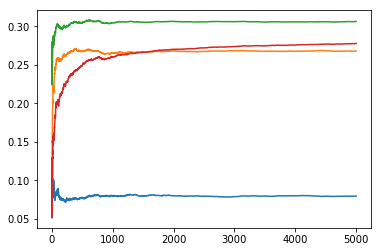

In [610]:
plt.plot(k[:,[0, 1, 2, 6]])
plt.show()

On observe que l'algorithme LinUCB est effectivement meilleur que le témoin tricheur moyen, et permet donc, si l'on dispose d'une description de contexte adéquate, d'obtenir de meilleurs résultats que si l'on ne 